# IEEE Quantum Week 2024 - TUT28 
## Transpilation of Utility-Scale Quantum Circuits 
### Part II: AI Transpiler Passes
**Authors: Ali Javadi, David Kremer**

**IBM Quantum**

In this notebook, we show how you can get the most out of the AI Transpiler passes and the Qiskit Transpiler Service.

You can find an overview in this blog post:

- [https://www.ibm.com/quantum/blog/ai-transpiler-passes](https://www.ibm.com/quantum/blog/ai-transpiler-passes)

More detailed documentation can be found here:

- [https://docs.quantum.ibm.com/guides/ai-transpiler-passes](https://docs.quantum.ibm.com/guides/ai-transpiler-passes)

And you can check the arXive paper for the details on the AI methods:

- [https://arxiv.org/abs/2405.13196](https://arxiv.org/abs/2405.13196)

In [1]:
#!pip install qiskit_ibm_transpiler
#!pip install qiskit_ibm_runtime

In [2]:
from qiskit import QuantumCircuit

def print_2q_count_and_depth(circuit):
    circuit_without_swaps = circuit.decompose("swap")
    print(f"2q gates: {circuit_without_swaps.num_nonlocal_gates()} | 2q depth: {circuit_without_swaps.depth(lambda op: len(op.qubits)>=2)}")

def fix_gate_names(circuit):
    # Fix gate names for display
    for gate in circuit:
        if gate.operation.name.startswith("unitary"):
            gate.operation.name = "unitary"
    return circuit


# 1. Playing with AI Transpiler Passes

### 1.1 AI Synthesis

AI Synthesis passes allow you synthesize Clifford, LinearFunction and Permutation blocks following a given coupling map.

They are guarenteed to implement the exact operation following the coupling map, and provide a good balance between optimality and computation time.

In [3]:
from qiskit_ibm_transpiler.ai.synthesis import AILinearFunctionSynthesis, AIPermutationSynthesis, AICliffordSynthesis

from qiskit_ibm_transpiler.ai.collection import CliffordInstruction
from qiskit.circuit.library import LinearFunction, PermutationGate

#### Clifford circuits

Cliffor circuits are circuits that can be implemented with H, S and CX gates (more info [here](https://docs.quantum.ibm.com/api/qiskit/qiskit.quantum_info.Clifford)).

Any Clifford circuit can be expressed as a 2N by 2N boolean matrix plus a 2N boolean vector for phase.

We can create a random 6 qubit Clifford like this:

In [4]:
from qiskit.quantum_info import Clifford, random_clifford
some_clifford = random_clifford(6)
some_clifford

Clifford(array([[False,  True, False, False, False, False,  True,  True,  True,
         True,  True, False,  True],
       [False, False,  True, False, False,  True, False,  True, False,
        False,  True, False,  True],
       [False,  True,  True,  True,  True, False,  True, False, False,
        False, False, False, False],
       [False,  True,  True,  True, False, False, False,  True,  True,
        False, False, False,  True],
       [ True,  True, False,  True, False, False,  True,  True,  True,
         True, False, False,  True],
       [ True, False, False, False, False,  True, False,  True,  True,
        False,  True,  True,  True],
       [False, False, False,  True, False,  True,  True, False, False,
        False, False, False, False],
       [False,  True, False, False,  True,  True, False, False, False,
         True,  True,  True,  True],
       [False, False, False, False, False, False,  True, False,  True,
         True,  True,  True,  True],
       [False, Fals

We can get an implementation of this Clifford with the standard method in Qiskit SDK, but it does not follow any coupling map (it assumes full connectivity):

2q gates: 19 | 2q depth: 16


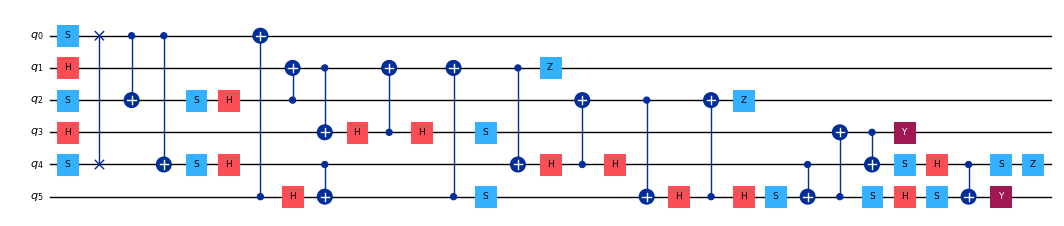

In [5]:
some_clifford_circuit = QuantumCircuit(some_clifford.num_qubits)
some_clifford_circuit.append(some_clifford, range(some_clifford_circuit.num_qubits))
some_clifford_circuit = some_clifford_circuit.decompose("clifford")

print_2q_count_and_depth(some_clifford_circuit)
some_clifford_circuit.draw(output="mpl", fold=-1, scale=0.5)

If we wanted to make this follow a coupling map, we would have to run a routing algorithm (e.g. `SabreSwap`). 

Lets transpile it for linear connectivity:

2q gates: 73 | 2q depth: 51


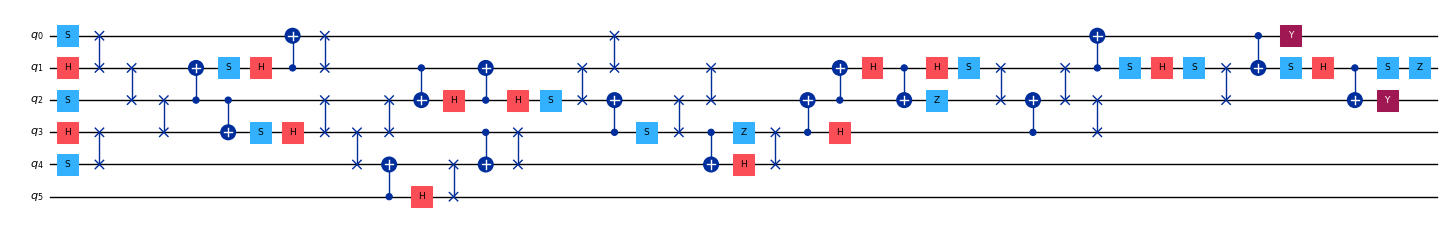

In [6]:
from qiskit.transpiler.passes import SabreSwap
from qiskit.transpiler import CouplingMap

coupling_map_6qL = CouplingMap.from_line(some_clifford_circuit.num_qubits)
sabre_swap = SabreSwap(coupling_map=coupling_map_6qL)

some_clifford_circuit_routed = sabre_swap(some_clifford_circuit)

print_2q_count_and_depth(some_clifford_circuit_routed)
some_clifford_circuit_routed.draw(output="mpl", fold=-1, scale=0.5)

We can see that this would work but there may be better ways to do it with less overhead. 

Also, note that after the routing we are not guaranteed to revert the final permutation, so we cannot use this as it is if we wanted to replace a clifford block within a larger circuit:

In [7]:
Clifford(some_clifford_circuit_routed) == some_clifford

np.False_

Lets see how we can do this with the `AICliffordSynthesis` pass.

First we embed the clifford into a block:

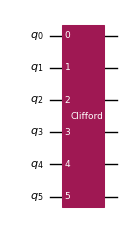

In [8]:
some_clifford_circuit_block = QuantumCircuit(some_clifford_circuit.num_qubits)
some_clifford_circuit_block.append(CliffordInstruction(some_clifford_circuit), range(some_clifford_circuit.num_qubits))

some_clifford_circuit_block.draw(output="mpl", fold=-1, scale=0.5)

Then we generate an instance of the `AICliffordSynthesis`:

In [9]:
ai_clifford_synth = AICliffordSynthesis(
    coupling_map=list(coupling_map_6qL.get_edges()),   # WIP (should be "coupling_map=...")
    replace_only_if_better=False,  # This means the pass will replace the block even if it has more cx than original circuit
)

Finally, we run the Synthesis on the circuit:

2q gates: 22 | 2q depth: 14


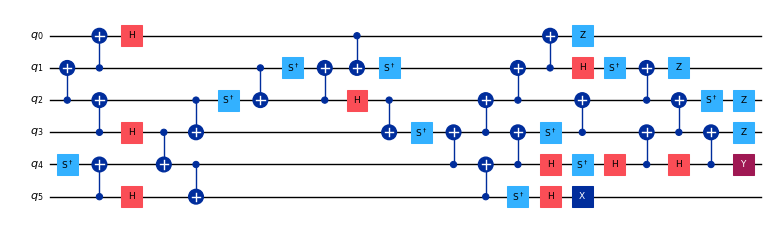

In [10]:
some_clifford_ai_synth = ai_clifford_synth(some_clifford_circuit_block)

print_2q_count_and_depth(some_clifford_ai_synth)
some_clifford_ai_synth.draw(output="mpl", fold=-1, scale=0.5)

We can see that the circuit follows the coupling map, and uses much less CX gates (around 50%-70% for random Cliffords).

We can also check that it implements the exact Clifford including final permutations:

In [11]:
Clifford(some_clifford_ai_synth) == some_clifford

np.True_

### *Hands-on exercise*:
*Try Clifford synthesis on a 7 qubit 'H' shaped coupling map*

In [12]:
#...

#### LinearFunctions and Permutations

LinearFunctions are circuits that can be implemented with CX gates (so they are a subset of Cliffords), and can be represented by a boolean N by N matrix.

Permutations are a subset of LinearFunctions and can be implemented with SWAP gates. They implement a permutation of the qubits so they can be represented by a permutation array of N elements.

We can do AI Synthesis in the same way as for Cliffords.

First we build a LinearFunction with a CX between qubit 0 and qubit 7:

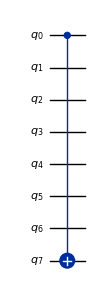

In [13]:
# The original circuit
some_lf_circuit = QuantumCircuit(8)
some_lf_circuit.cx(0,7)
some_lf_circuit.draw(output="mpl", fold=-1, scale=0.5)

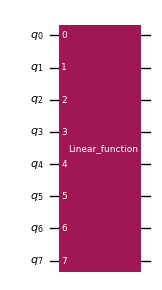

In [14]:
# The LinearFunction object
some_lf = LinearFunction(some_lf_circuit)

# The block with the LinearFunction
some_lf_block = QuantumCircuit(some_lf.num_qubits)
some_lf_block.append(some_lf, range(some_lf_block.num_qubits))

some_lf_block.draw(output="mpl", fold=-1, scale=0.5)

Then we generate our `AILinearFunctionSynthesis` pass:

In [15]:
coupling_map_8qL = CouplingMap.from_line(some_lf_block.num_qubits)

ai_lf_synth = AILinearFunctionSynthesis(
    coupling_map=list(coupling_map_8qL.get_edges()),   # WIP (should be "coupling_map=...")
    replace_only_if_better=False,
)

And we run the pass on the circuit:

2q gates: 24 | 2q depth: 19


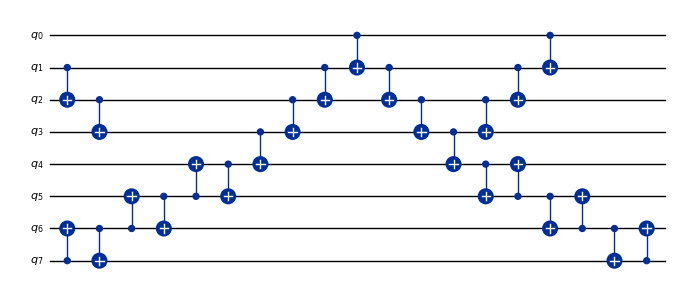

In [16]:
some_lf_ai_synth = ai_lf_synth(some_lf_block)

print_2q_count_and_depth(some_lf_ai_synth)
some_lf_ai_synth.draw(output="mpl", fold=-1, scale=0.5)

### *Hands-on exercise*:
*Compare with running routing on the single CX circuit*

In [17]:
#...

### *Hands-on exercise*:
*Implement a full inversion permutation on 27 qubits heavy-hex with the `AIPermutationSynthesis` pass*.

*Also compare with `TokenSwapperSynthesisPermutation`*.

In [18]:
from qiskit.transpiler.passes.synthesis.high_level_synthesis import TokenSwapperSynthesisPermutation
from qiskit_ibm_runtime.fake_provider.backends.montreal import FakeMontrealV2

coupling_map_27qHH = FakeMontrealV2().coupling_map

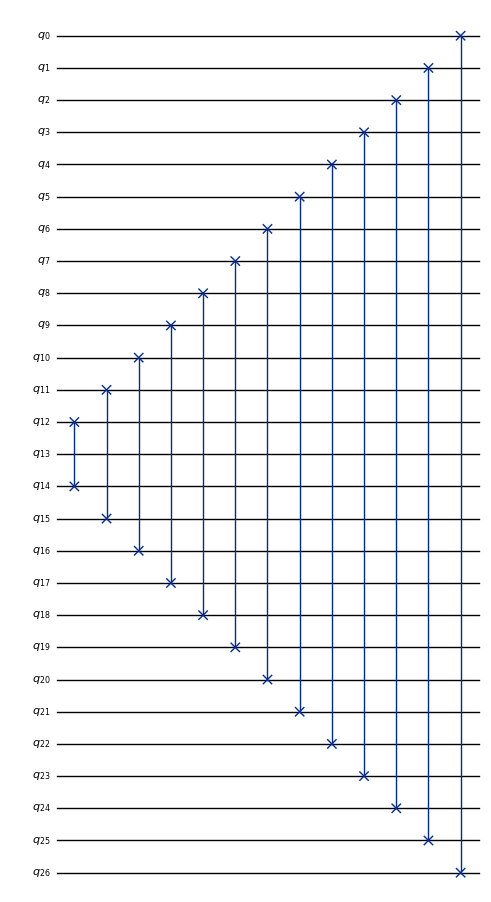

In [19]:
circuit_perm = QuantumCircuit(27)

perm = list(reversed(range(27)))
perm_gate = PermutationGate(perm)

# The permutation circuit
circuit_perm.append(perm_gate, qargs=range(27))
circuit_perm.decompose("permutation").draw(output="mpl", fold=-1, scale=0.5)

In [20]:
# AI synthesis
ai_synth_perm = AIPermutationSynthesis(
    coupling_map=list(coupling_map_27qHH.get_edges()),  # WIP (should be "coupling_map=...")
    replace_only_if_better=False
)

# Token swapper
ts_synth_perm = TokenSwapperSynthesisPermutation()

2q gates: 489 | 2q depth: 231


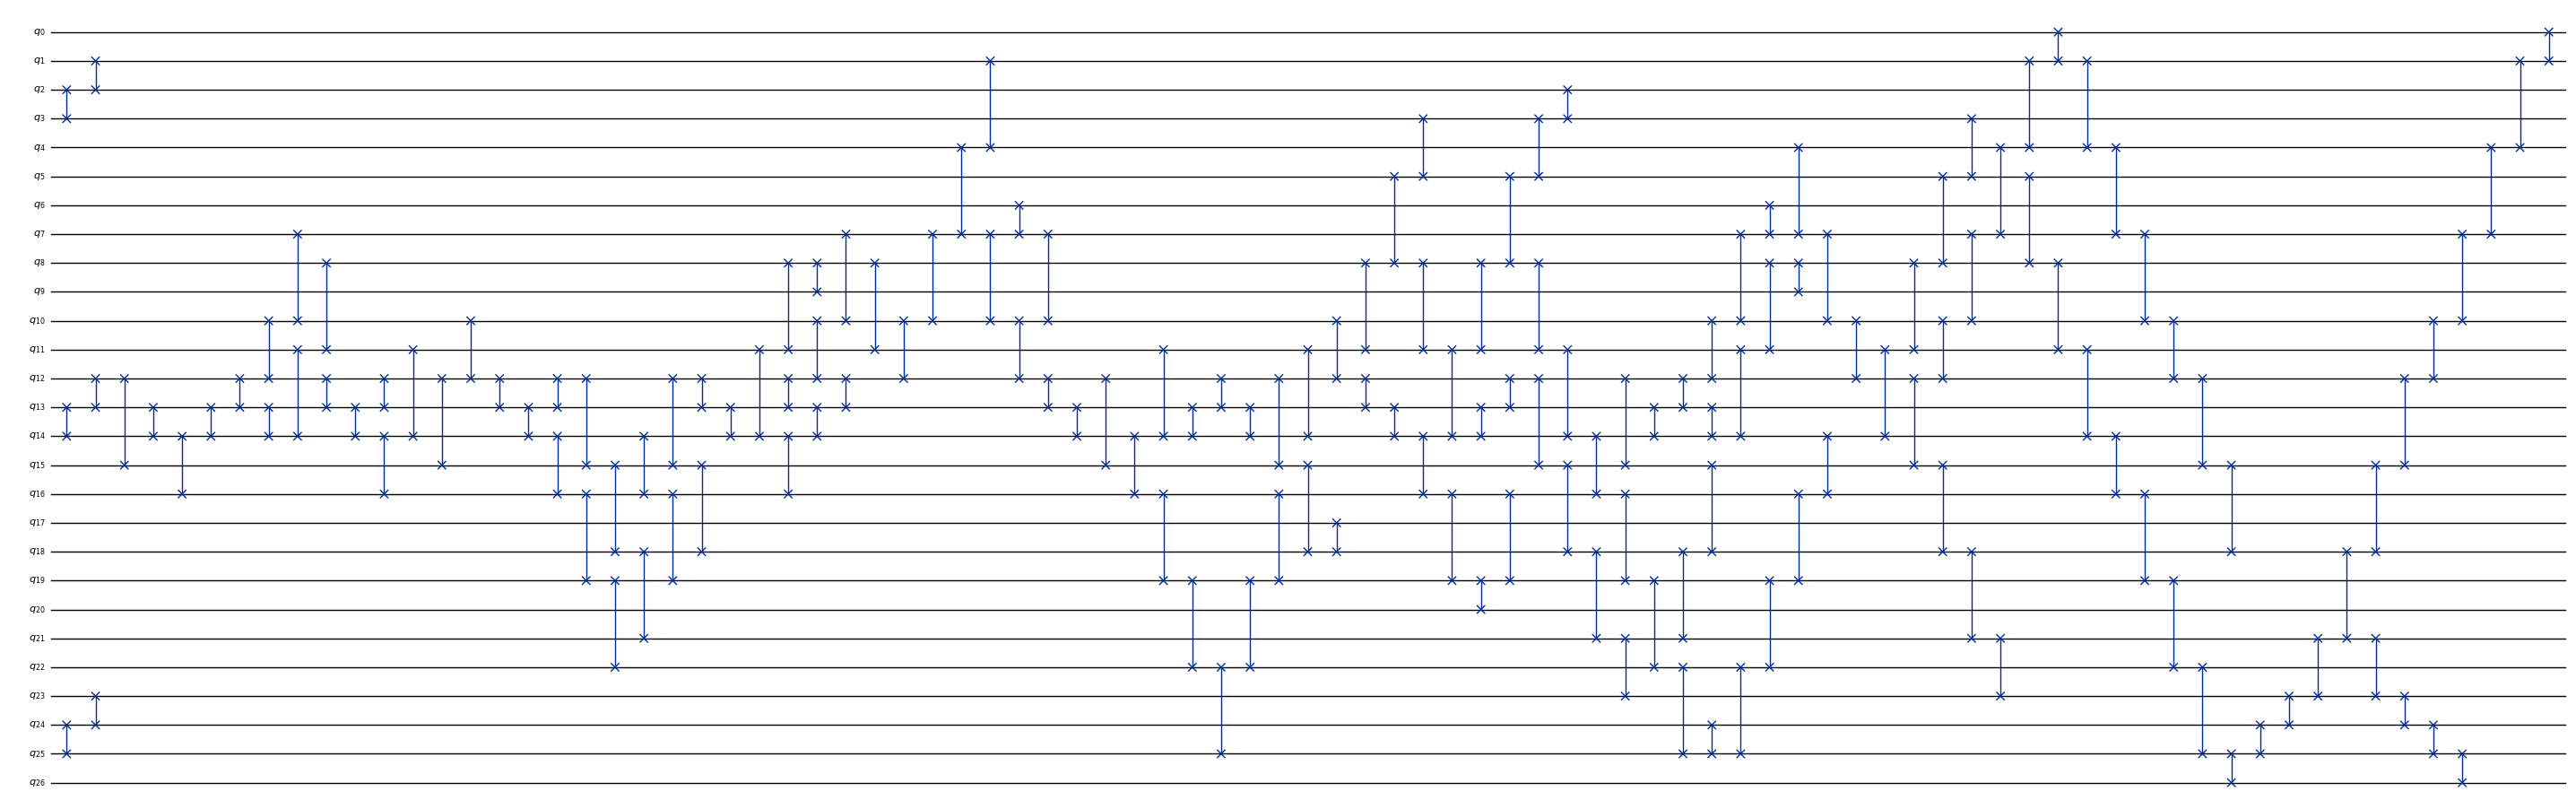

In [21]:
circuit_perm_ts = ts_synth_perm.run(perm_gate, coupling_map=coupling_map_27qHH, qubits=range(27))

print_2q_count_and_depth(circuit_perm_ts)
circuit_perm_ts.draw(output="mpl", fold=-1, scale=0.5)

2q gates: 441 | 2q depth: 102


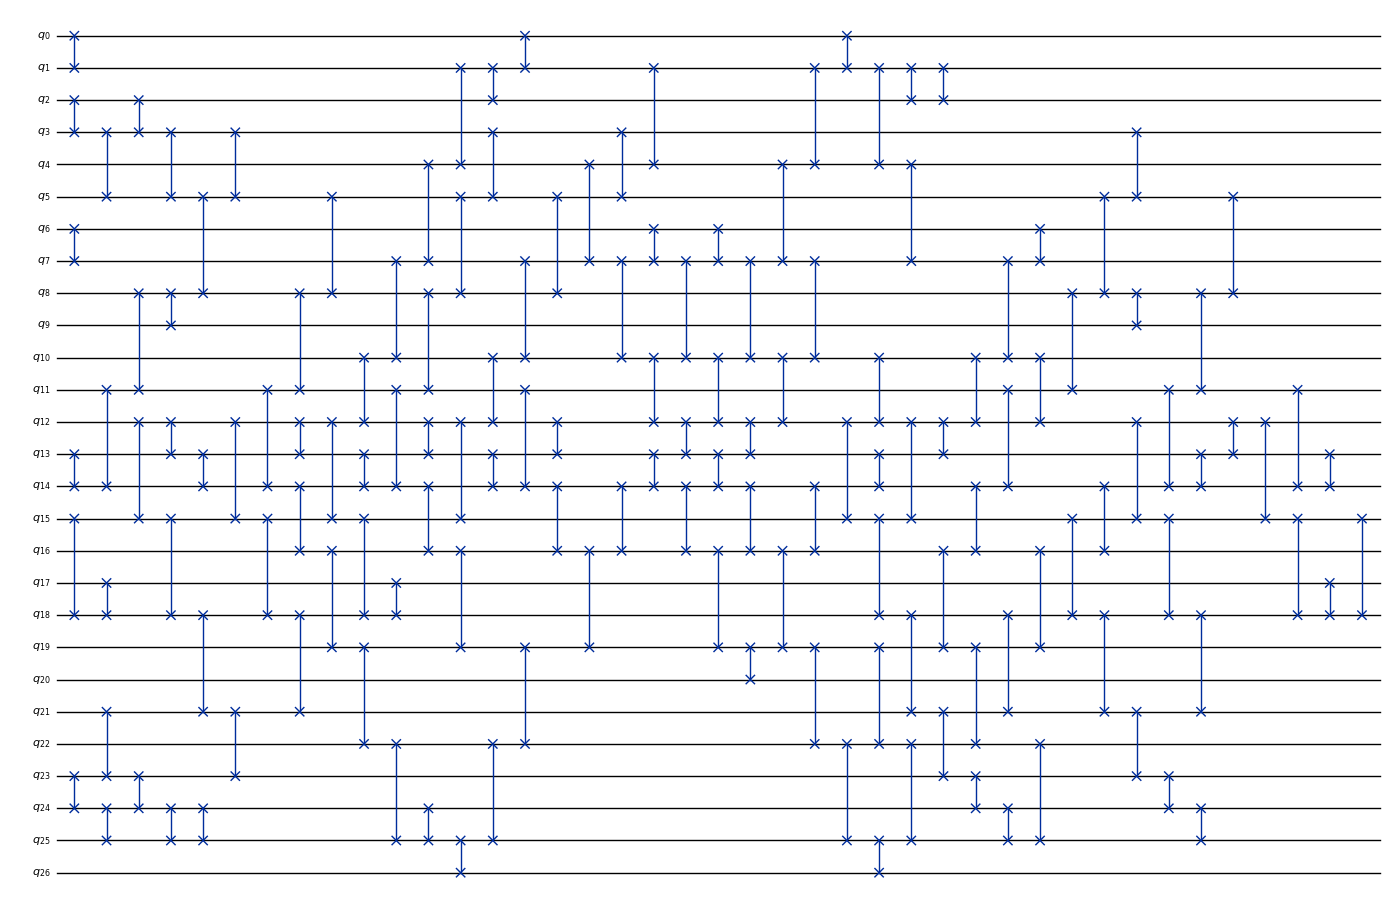

In [22]:
circuit_perm_ai = ai_synth_perm(circuit_perm)

print_2q_count_and_depth(circuit_perm_ai)
circuit_perm_ai.draw(output="mpl", fold=-1, scale=0.5)

### 1.2 AI Routing

In the context of transpiling, Routing consists on inserting SWAP gates to make the 2q gates in a circuit compatible with a given coupling map.

Layout selection is a related task that consists on assigning physical qubits to the virtual qubits on the circuit. Typically, this two tasks are coupled together, since a good layout will make routing easier. 


Qiskit SDK provides a powerful Routing and Layout algorithm (`SabreSwap` and `SabreLayout`) that often provides a good routing solution efficiently. 

However, we have seen that this can be improved (sometimes by a large margin) with the AIRouting pass.

In [23]:
from qiskit_ibm_transpiler.ai.routing import AIRouting
from qiskit.transpiler.passes import SabreSwap, SabreLayout

Lets try routing circuits to a 12 qubit ring:

In [24]:
coupling_map_12qO = [(i, (i+1) % 12) for i in range(12)]   # A 12 qubit ring
coupling_map_12qO_qk = CouplingMap(coupling_map_12qO)
coupling_map_12qO_qk.make_symmetric()

Next, we create our passes. For just routing:

In [25]:
# AI routing, keeping current layout

ai_routing_3_keep = AIRouting(
    coupling_map=coupling_map_12qO,   # This can be a list or a CouplingMap object
    optimization_level=3,            # 1, 2 or 3
    layout_mode="keep",          # "keep", "improve" or "optimize" for layout
)

# SabreSwap, only routing and keeping layout

sabre_swap = SabreSwap(coupling_map=coupling_map_12qO_qk)

And, for optimizing both layout and routing:

In [26]:
# AI routing for optimizing layout

ai_routing_3_optimize = AIRouting(
    coupling_map=coupling_map_12qO,   # This can be a list or a CouplingMap object
    optimization_level=3,            # 1, 2 or 3
    layout_mode="optimize",          # "keep", "improve" or "optimize" for layout
)

# SabreLayout, doing both routing and layout optimization

sabre_layout = SabreLayout(coupling_map=coupling_map_12qO_qk)


We can now try the different methods some circuits:

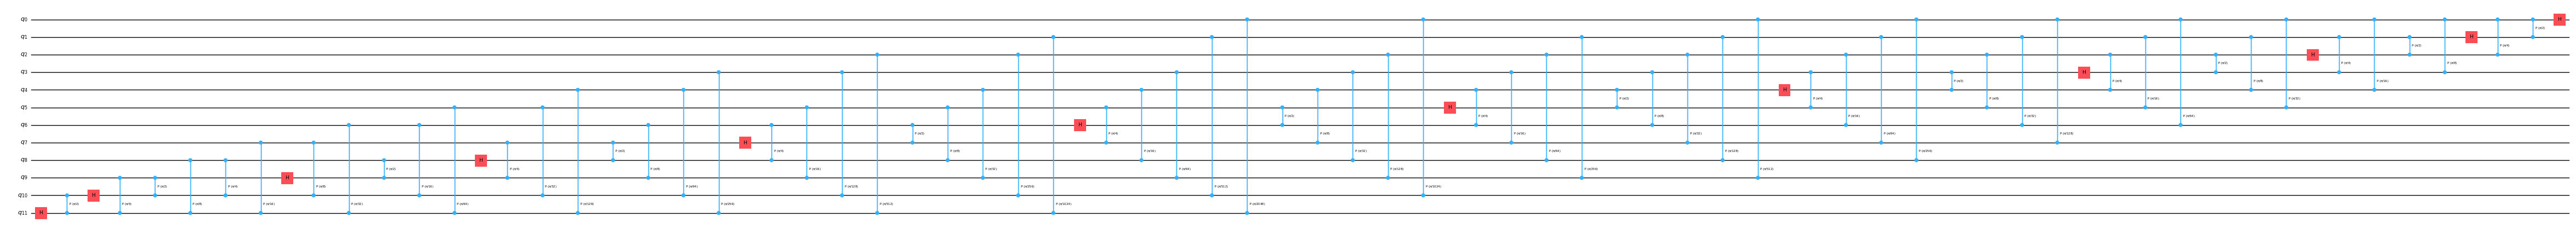

In [27]:
from qiskit.circuit.library import QFT

circuit = QFT(12, do_swaps=False).decompose()
circuit.draw(output="mpl", scale=0.5, fold=-1)

In [28]:
circuit_routed_ai_opt = fix_gate_names(ai_routing_3_optimize(circuit))

In [29]:
circuit_routed_ai_keep = fix_gate_names(ai_routing_3_keep(circuit))

In [30]:
circuit_routed_sabre_layout = sabre_layout(circuit)
circuit_routed_sabre_swap = sabre_swap(circuit)

AI routing
2q gates: 255 | 2q depth: 92


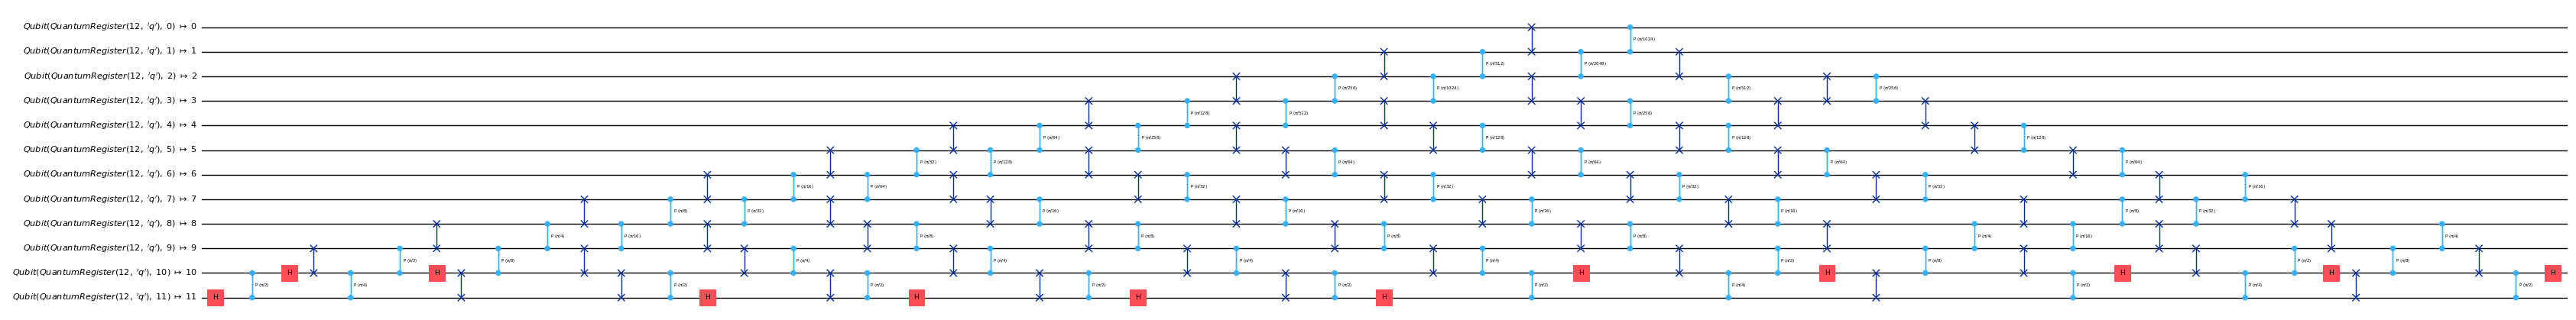

In [31]:
print("AI routing")
print_2q_count_and_depth(circuit_routed_ai_keep)
circuit_routed_ai_keep.draw(output="mpl", fold=-1, scale=0.5)

Sabre routing
2q gates: 291 | 2q depth: 121


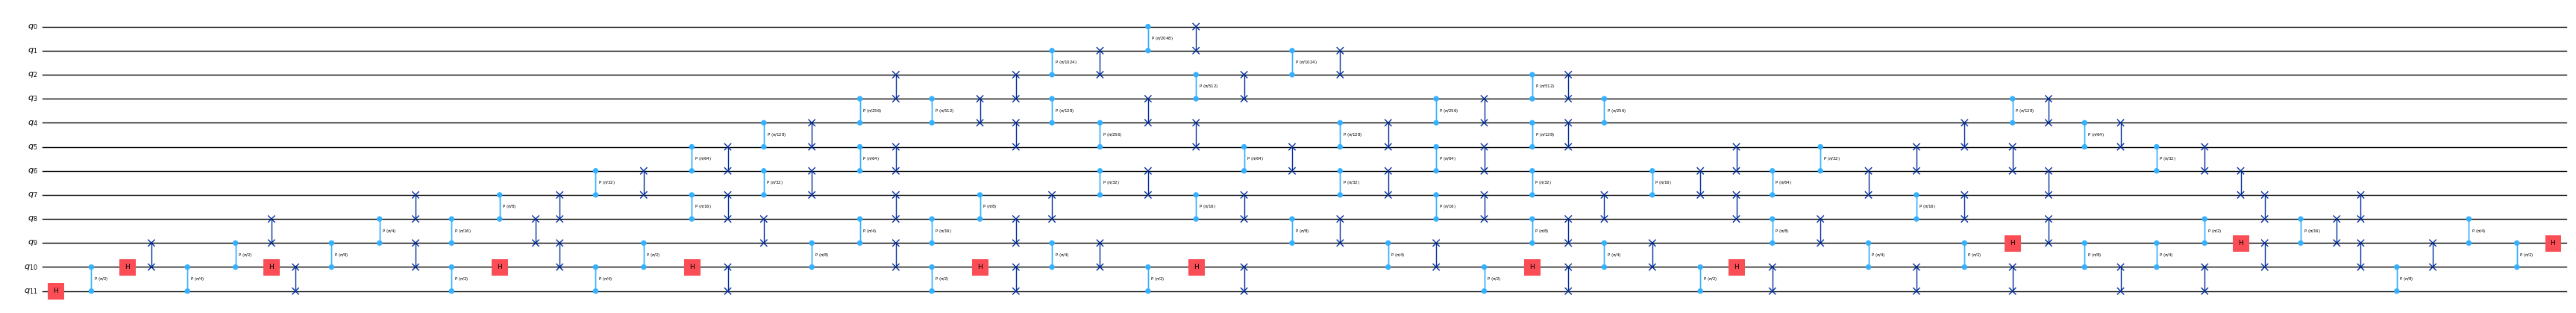

In [32]:
print("Sabre routing")
print_2q_count_and_depth(circuit_routed_sabre_swap)
circuit_routed_sabre_swap.draw(output="mpl", fold=-1, scale=0.5)

AI layout + routing
2q gates: 258 | 2q depth: 83


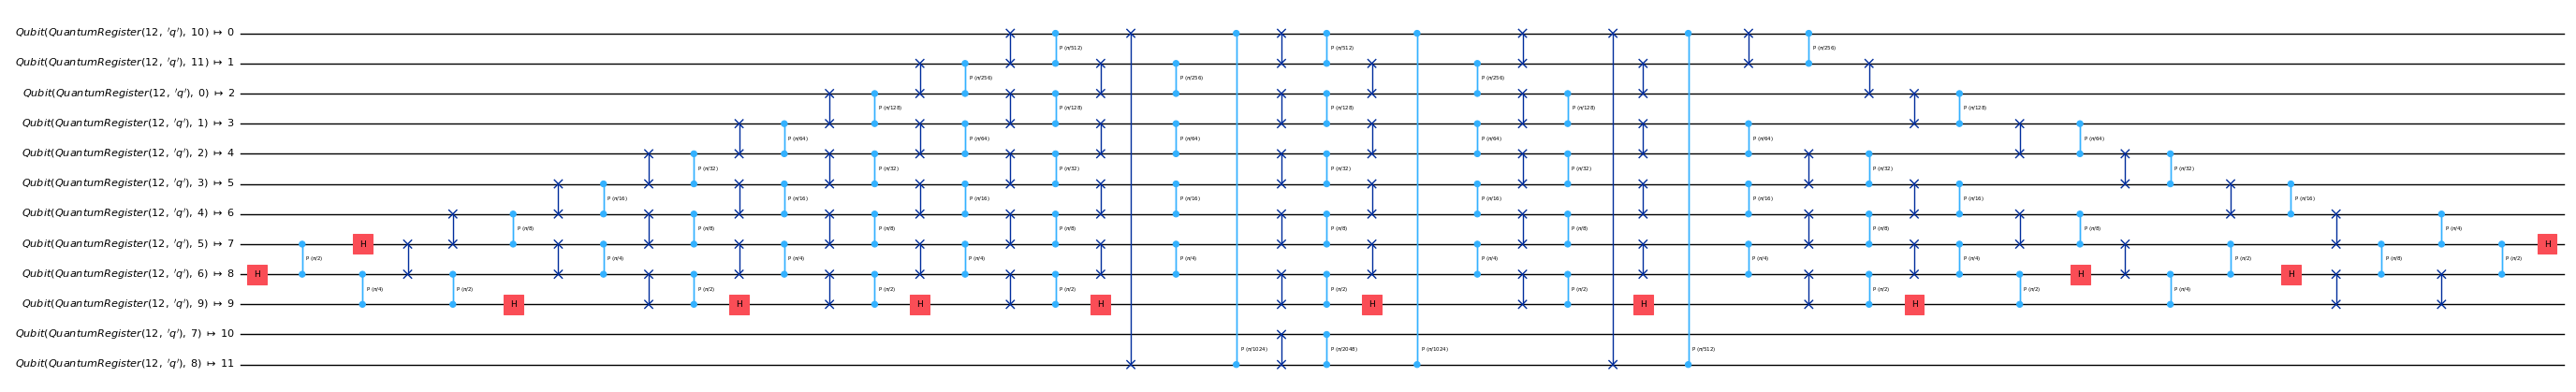

In [33]:
print("AI layout + routing")
print_2q_count_and_depth(circuit_routed_ai_opt)
circuit_routed_ai_opt.draw(output="mpl", fold=-1, scale=0.5)

Sabre layout + routing
2q gates: 309 | 2q depth: 134


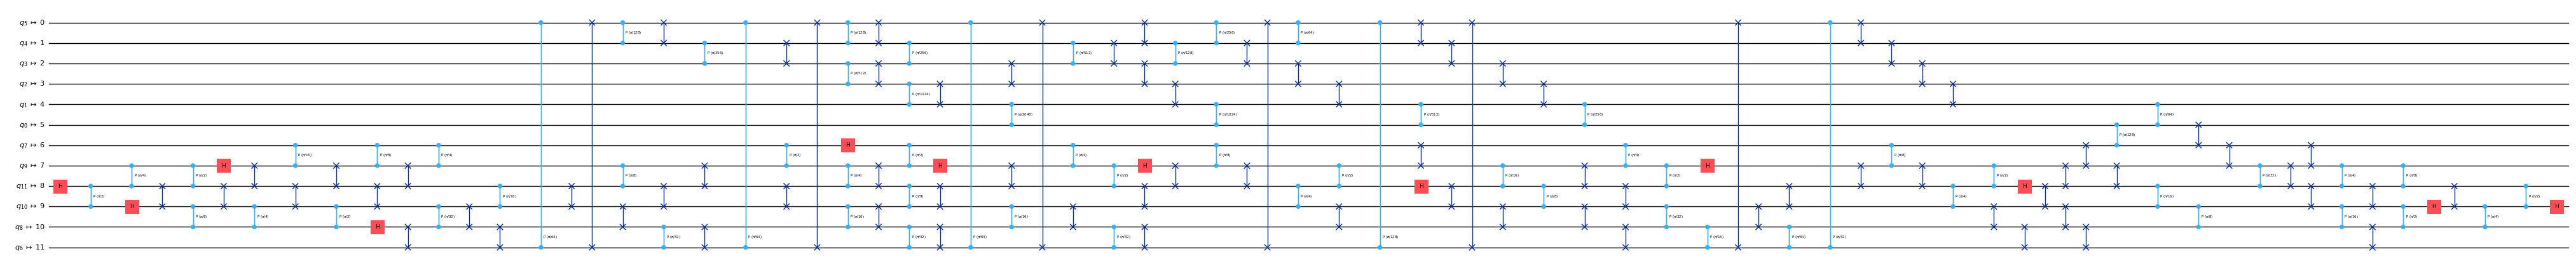

In [34]:
print("Sabre layout + routing")
print_2q_count_and_depth(circuit_routed_sabre_layout)
circuit_routed_sabre_layout.draw(output="mpl", fold=-1, scale=0.5)

### 1.2 Collecting and re-synthesizing circuit blocks

We can use the AI synthesis passes for additional optimization after routing, since they preserve the coupling map.

This can be done by first collecting blocks to be resinthesized, and then running the AI synthesis pass.

In [35]:
from qiskit_ibm_transpiler.ai.collection import CollectLinearFunctions, CollectCliffords, CollectPermutations

We can create a collection pass like this (in this case for LinearFunctions):

In [36]:
collect_lfs = CollectLinearFunctions(
    do_commutative_analysis=True,
    min_block_size=0,
    max_block_size=9,   # Max size supported for now
    collect_from_back=False
)

ai_lf_synth_12q = AILinearFunctionSynthesis(
    coupling_map=list(coupling_map_12qO_qk.get_edges()),
    replace_only_if_better=True,   # If the resynthesized circuit is "worse", we keep the original
)

First, we create a circuit and route it:

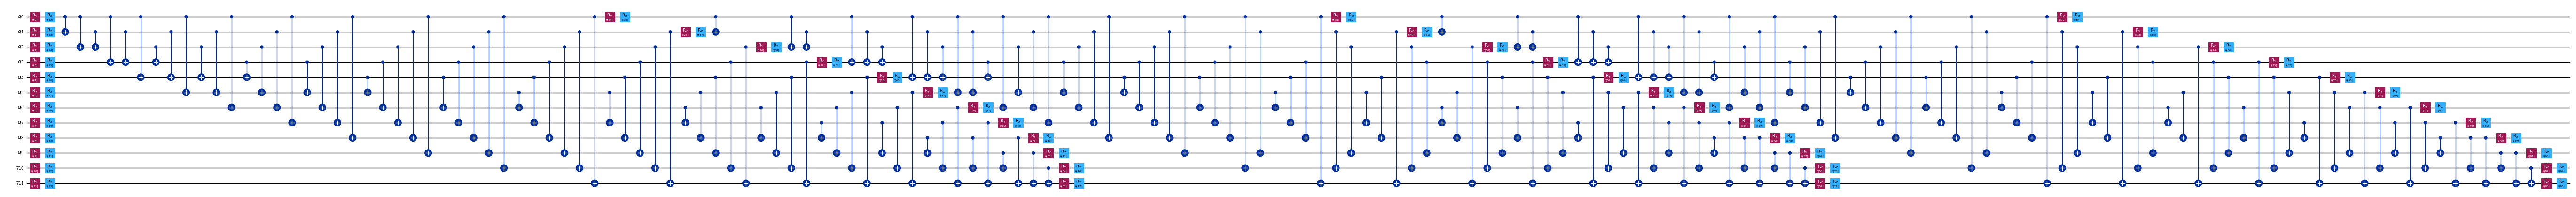

In [37]:
from qiskit.circuit.library import EfficientSU2

circuit = EfficientSU2(12, entanglement="full").decompose()
circuit.draw(output="mpl", scale=0.5, fold=-1)

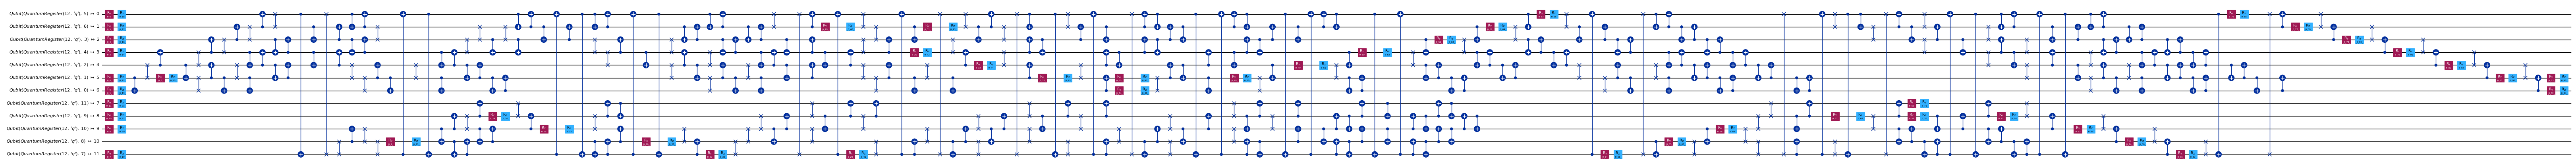

In [38]:
circuit_routed = ai_routing_3_optimize(circuit)
circuit_routed.draw(output="mpl", scale=0.5, fold=-1)

Then we run the pass on the circuit to get the blocks.

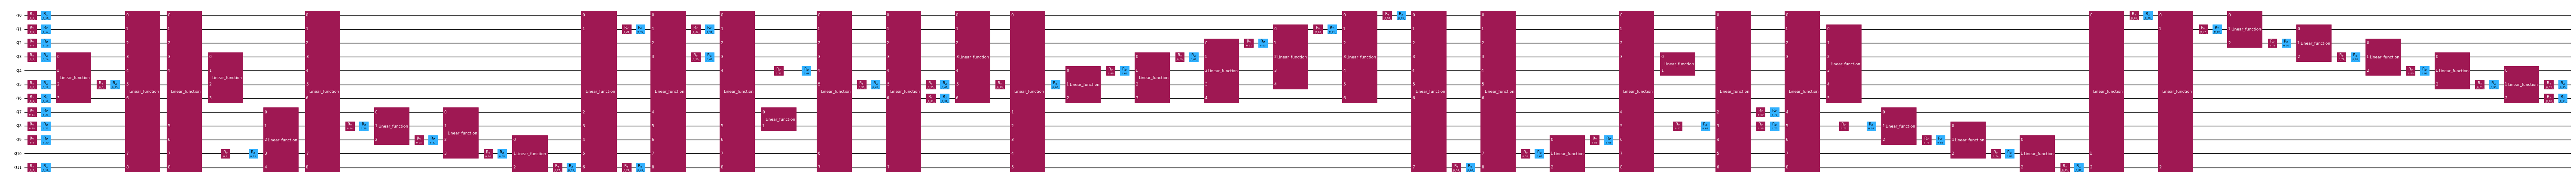

In [39]:
circuit_collected = collect_lfs(circuit_routed.decompose("swap"))
circuit_collected.draw(output="mpl", scale=0.5, fold=-1)

Finall, we run the synthesis pass to replace all the blocks with optimized versions:

In [40]:
circuit_optimized = ai_lf_synth_12q(circuit_collected)
print("Before optimization:")
print_2q_count_and_depth(circuit_routed)
print("After optimization:")
print_2q_count_and_depth(circuit_optimized)

Before optimization:
2q gates: 610 | 2q depth: 201
After optimization:
2q gates: 491 | 2q depth: 183


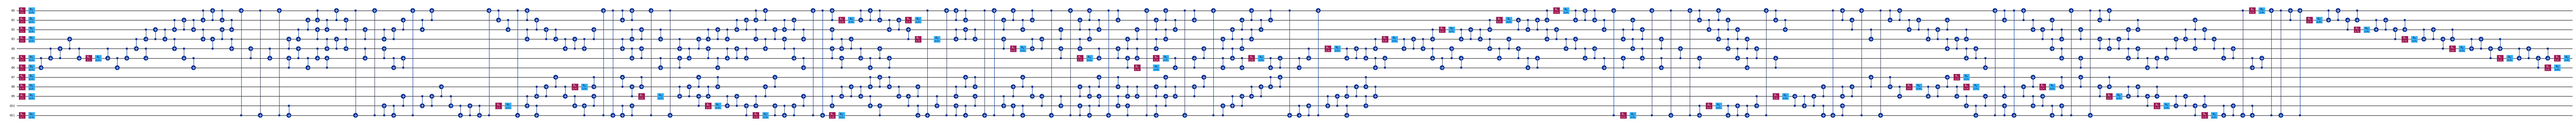

In [41]:
circuit_optimized.draw(output="mpl", scale=0.5, fold=-1)

### *Hands-on exercise*:
*Create a custom `PassManager` that includes AI routing, block collection and AI synthesis and run it on some circuits.*

In [42]:
from qiskit.transpiler import PassManager
#...

In [43]:
ai_transpiling = PassManager([
    ai_routing_3_optimize,
    collect_lfs,
    ai_lf_synth_12q
])

In [44]:
circuit_ai_transpiled = ai_transpiling.run(circuit)

2q gates: 498 | 2q depth: 224


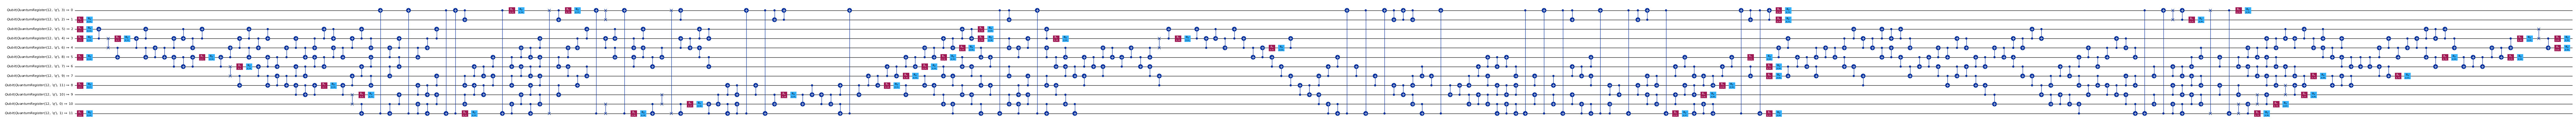

In [45]:
print_2q_count_and_depth(circuit_ai_transpiled)
circuit_ai_transpiled.draw(output="mpl", scale=0.5, fold=-1)

# 2. Transpiling on the cloud with the Qiskit Transpiler Service

The Qiskit Transpiler Service allows you to run a full transpiler pipeline on the cloud. 

You can run 3 predefined pipelines:

- With `ai='false'`, it will run the standard Qiskit SDK transpiling pipeline (with the specified options).
- With `ai='true'`, it will run an "ai-enhanced" pipeline, based on the standard Qiskit SDK including AI passes for further optimization.
- With `ai='auto'`, it will return the best of both, so you don't have to worry about comparing!

More information here:
 - [https://docs.quantum.ibm.com/guides/qiskit-transpiler-service](https://docs.quantum.ibm.com/guides/qiskit-transpiler-service)


In [46]:
from qiskit_ibm_transpiler import TranspilerService

In [47]:
circuit = EfficientSU2(20, entanglement="full").decompose()

In [48]:
transpiler_ai = TranspilerService(
    optimization_level=2,  # 1, 2 or 3
    backend_name="ibm_sherbrooke",  # here you can include any existing IBM device name
    ai="true",  # 'true', 'false' or 'auto'
    qiskit_transpile_options={},  # here you can send any additional transpiler options 
    ai_layout_mode="optimize"  # 'keep', 'improve' or 'optimize' (same as for AI routing pass)
)

transpiler_qk = TranspilerService(
    optimization_level=2,  # 1, 2 or 3
    backend_name="ibm_sherbrooke",  # here you can include any existing IBM device name
    ai="false",  # 'true', 'false' or 'auto'
    qiskit_transpile_options={},  # here you can send any additional transpiler options 
)

Lets run it on the circuit:

In [49]:
circuit_full_transpile_ai = transpiler_ai.run(circuit)
print_2q_count_and_depth(circuit_full_transpile_ai)
print(circuit_full_transpile_ai.count_ops())

2q gates: 1397 | 2q depth: 367
OrderedDict([('rz', 5132), ('sx', 2780), ('ecr', 1397), ('x', 226)])


In [50]:
circuit_full_transpile_qk = transpiler_qk.run(circuit)
print_2q_count_and_depth(circuit_full_transpile_qk)
print(circuit_full_transpile_qk.count_ops())

2q gates: 2270 | 2q depth: 767
OrderedDict([('rz', 7438), ('sx', 4170), ('ecr', 2270), ('x', 331)])


Since it is doing the full transpilation for the device, it is also translating the gates to the native gates of the device, so the result should be directly executable on the quantum device.

We can also customize all this by providing a coupling map, an initial layout and a list of supported instructions for the transpilation:

In [51]:
# The custom options
qiskit_transpile_options = {
    "basis_gates": ["cz", "x", "sx", "rz", "id", "measure"],
    "initial_layout": list(range(circuit.num_qubits))
}

transpiler_custom_ai = TranspilerService(
    optimization_level=2,  # 1, 2 or 3
    coupling_map=list(coupling_map_27qHH.get_edges()),  # your coupling map
    ai="true",  # 'true', 'false' or 'auto'
    qiskit_transpile_options=qiskit_transpile_options,  # here you can send any additional transpiler options 
    ai_layout_mode="improve",  # 'keep', 'improve' or 'optimize' (same as for AI routing pass)
)

transpiler_custom_qk = TranspilerService(
    optimization_level=2,  # 1, 2 or 3
    coupling_map=list(coupling_map_27qHH.get_edges()),  # your coupling map
    ai="false",  # 'true', 'false' or 'auto'
    qiskit_transpile_options=qiskit_transpile_options,  # here you can send any additional transpiler options 
)

In [52]:
circuit_custom_transpile_ai = transpiler_custom_ai.run(circuit)
print_2q_count_and_depth(circuit_custom_transpile_ai)
print(circuit_custom_transpile_ai.count_ops())

2q gates: 1994 | 2q depth: 500
OrderedDict([('sx', 3437), ('cz', 1994), ('rz', 1796), ('x', 8)])


In [53]:
circuit_custom_transpile_qk = transpiler_custom_qk.run(circuit)
print_2q_count_and_depth(circuit_custom_transpile_qk)
print(circuit_custom_transpile_qk.count_ops())

2q gates: 2647 | 2q depth: 853
OrderedDict([('sx', 4823), ('cz', 2647), ('rz', 1637), ('x', 31)])


## *3. Hands-on exercise:*
*Combine AI passes with other specialized passes to build custom pipelines, and try it on your circuits!*